In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score

import numpy as np
import torch

import librosa
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Sampler

import os
import tqdm.notebook as tqdm

import json

import time
import datetime
import math

In [2]:
from transforms import *
from loss_functions import *
from datasets import *
from models import *
from torchvision.transforms import Compose
from clustering_metrics import *

In [3]:
train_dataset_path = 'datasets/speech_commands/train'
valid_dataset_path = 'datasets/speech_commands/validation'
test_dataset_path = 'datasets/speech_commands/test'

In [4]:
device = torch.device('cpu')
use_gpu = False
if torch.cuda.is_available():
        use_gpu = True
        device = torch.device('cuda', 0)

# Train Loop

In [5]:

def training_loop(start_epoch, n_epochs, model, loss_fn, optimizer, dl_train, dl_valid, device, save_config):
    train_losses, valid_losses = [], []
    train_epoch, valid_epoch = [], []

    experiment_name = save_config['experiment_name']
    experiments_folder = save_config['experiments_folder']

    experiment_folder = os.path.join(experiments_folder, experiment_name)
    checkpoints_folder = os.path.join(experiment_folder, "checkpoints")
    os.makedirs(experiment_folder, exist_ok=True)
    os.makedirs(checkpoints_folder, exist_ok=True)

    for epoch in (pbar := tqdm.tqdm(range(n_epochs), total=n_epochs, position = 0, leave=True)):
        # Переводим сеть в режим обучения
        model.train()

        train_loss = 0
        iter_cnt = 0
        # Итерация обучения сети
        for batch in (pbar2 := tqdm.tqdm(dl_train, total=len(dl_train), position = 1, leave=False)):
            images = batch['input']
            images = torch.unsqueeze(images, 1)

            labels = batch['target']

            optimizer.zero_grad()
            
            images = images.to(device)
            labels = labels.to(device)

            net_out = model(images)
            loss = loss_fn(net_out, labels)
            
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

            iter_cnt += 1

            pbar2.set_description(
                'Loss Train: {0:.5f}\n'.format(
                    loss.item()
                )
            )
        
        train_losses.append(train_loss / iter_cnt)
        train_epoch.append(epoch)
        
        # Оцениваем качество модели каждые 3 итерации
        if dl_valid:
            if epoch % 3 == 0 or epoch == n_epochs - 1:
                model.eval()
                with torch.no_grad():
                    iter_cnt = 0
                    loss_sum = 0

                    for batch in (pbar2 := tqdm.tqdm(dl_valid, total=len(dl_valid), position = 1, leave=False)):
                        images = batch['input']
                        images = torch.unsqueeze(images, 1)

                        labels = batch['target']

                        images = images.to(device)
                        labels = labels.to(device)
                    
                        net_out = model(images)
                        loss = loss_fn(net_out, labels)

                        loss_sum += loss.item()
                        iter_cnt += 1
                        
                        pbar2.set_description(
                            'Loss Valid: {0:.5f}\n'.format(
                                loss.item()
                            )
                        )
                    
                    valid_losses.append(loss_sum / iter_cnt)
                    valid_epoch.append(epoch)
    
        checkpoint = {
            'epoch': start_epoch + epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }

        torch.save(checkpoint, os.path.join(checkpoints_folder, f"checkpoint_{start_epoch + epoch}"))

        if dl_valid:
            pbar.set_description(
                        'Loss (Train/Valid): {0:.5f}/{1:.5f}\n'.format(
                            train_losses[-1], valid_losses[-1]
                        )
                    )
        else:
            pbar.set_description(
                        'Loss (Train): {0:.5f}\n'.format(
                            train_losses[-1]
                        )
                    )

    losses = {
        'train': train_losses,
        'train_epoch': train_epoch,
    }
    
    if dl_valid:
        losses['valid'] = valid_losses
        losses['valid_epoch'] = valid_epoch

    return losses

# Putting all togather

In [6]:
device = torch.device('cpu')
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
    device = torch.device('cuda', 0)
    
print(type(device), device)

# may benefit if network size/input/output is stable
if use_gpu:
    torch.backends.cudnn.benchmark = True

background_noise_path = 'datasets/speech_commands/_background_noise_'
train_dataset_path = 'datasets/speech_commands/train'
valid_dataset_path = 'datasets/speech_commands/validation'

<class 'torch.device'> cuda:0


In [20]:
def create_model(model_description):
        if 'name' not in model_description:
                return '[ERROR]: corrupted model description'

        if model_description['name'] == 'DSCNN':
                n_mels = model_description['n_mels']
                in_shape = (n_mels, 32)
                in_channels = model_description['in_channels']
                ds_cnn_number = model_description['ds_cnn_number']
                ds_cnn_size = model_description['ds_cnn_size']
                is_classifier = model_description['is_classifier']
                classes_number = 0 if not is_classifier else model_description['classes_number']

                return DSCNN(in_channels, in_shape, ds_cnn_number, ds_cnn_size, is_classifier, classes_number)


def do_experiment(experiment_settings):
        experiment_settings['time_start'] = str(datetime.datetime.now())
        experiment_folder = os.path.join(experiment_settings['experiments_folder'], experiment_settings['experiment_name'])

        background_noise_path = 'datasets/speech_commands/_background_noise_'

        train_dataset_path = 'datasets/speech_commands/train'
        valid_dataset_path = 'datasets/speech_commands/validation'

        if 'train_dataset' in experiment_settings.keys():
                if experiment_settings['train_dataset'] == 'speech_commands/train':
                        train_dataset_path = 'datasets/speech_commands/train'
                elif experiment_settings['train_dataset'] == 'speech_commands/valid':
                        train_dataset_path = 'datasets/speech_commands/validation'
                elif experiment_settings['train_dataset'] == 'speech_commands/test':
                        train_dataset_path = 'datasets/speech_commands/test'
        
        if 'valid_dataset'  in experiment_settings.keys():
                if experiment_settings['valid_dataset'] == 'speech_commands/train':
                        valid_dataset_path = 'datasets/speech_commands/train'
                elif experiment_settings['valid_dataset'] == 'speech_commands/valid':
                        valid_dataset_path = 'datasets/speech_commands/validation'
                elif experiment_settings['valid_dataset'] == 'speech_commands/test':
                        valid_dataset_path = 'datasets/speech_commands/test'
                elif experiment_settings['valid_dataset'] is None:
                        valid_dataset_path = None
        
        print(f"train_dataset_path = {train_dataset_path}")
        print(f"valid_dataset_path = {valid_dataset_path}")
                        

        # prepare device
        device = torch.device('cpu')
        use_gpu = False
        if torch.cuda.is_available():
                use_gpu = True
                device = torch.device('cuda', 0)
        
        print(type(device), device)

        if use_gpu:
                torch.backends.cudnn.benchmark = True

        print(f'Start experiment {experiment_settings["experiment_name"]} -- {str(datetime.datetime.now())}')

        save_config = {'experiment_name': experiment_settings['experiment_name'],
                'experiments_folder': experiment_settings['experiments_folder']}
        
        # prepare folder
        experiment_folder = os.path.join(experiment_settings['experiments_folder'], experiment_settings['experiment_name'])
        os.makedirs(experiment_folder, exist_ok=True)

        # create datasets
        n_mels = experiment_settings['model']['n_mels']

        data_aug_transform = Compose([ChangeAmplitude(), ChangeSpeedAndPitchAudio(), FixAudioLength(), ToSTFT(), StretchAudioOnSTFT(), TimeshiftAudioOnSTFT(), FixSTFTDimension()])

        bg_dataset = BackgroundNoiseDataset(background_noise_path, data_aug_transform)
        add_bg_noise = AddBackgroundNoiseOnSTFT(bg_dataset)


        train_feature_transform = Compose([ToMelSpectrogramFromSTFT(n_mels=n_mels), DeleteSTFT(), ToTensor('mel_spectrogram', 'input')])
        train_dataset = SpeechCommandsDataset(train_dataset_path,
                                        Compose([LoadAudio(),
                                                data_aug_transform,
                                                add_bg_noise,
                                                train_feature_transform]))

        if valid_dataset_path:
                valid_feature_transform = Compose([ToSTFT(), ToMelSpectrogramFromSTFT(n_mels=n_mels), ToTensor('mel_spectrogram', 'input')])
                valid_dataset = SpeechCommandsDataset(valid_dataset_path,
                                                Compose([LoadAudio(),
                                                        FixAudioLength(),
                                                        valid_feature_transform]))
    
        
        # Create model
        experiment_settings['model']['classes_number'] = train_dataset.get_classes_number()
        model = create_model(experiment_settings['model'])

        pytorch_total_params = sum(p.numel() for p in model.parameters())
        pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        experiment_settings['model']['total_params'] = pytorch_total_params
        experiment_settings['model']['train_params'] = pytorch_train_params

        print(f'Model total params: {pytorch_total_params}')
        print(f'Model train params: {pytorch_train_params}')

        batch_size = experiment_settings['batch_size']
        n_epoch = experiment_settings['n_epoch']

        if use_gpu:
                model = torch.nn.DataParallel(model).cuda()

        # create dataloaders
        loss_settings = experiment_settings['loss']
        if loss_settings['name'] == 'CrossEntropy':
                dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
                dl_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=16) if valid_dataset_path else None

                loss_fn = torch.nn.CrossEntropyLoss()
        elif loss_settings['name'] == 'TripletLoss':
                train_sampler = TripletBatchSampler(train_dataset.get_class_indices(), batch_size, 20)
                valid_sampler = TripletBatchSampler(valid_dataset.get_class_indices(), batch_size, 20) if valid_dataset_path else None

                dl_train = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=16)
                dl_valid = DataLoader(valid_dataset, batch_sampler=valid_sampler, num_workers=16) if valid_dataset_path else None
                
                margin = loss_settings['loss_margin'] if 'loss_margin' in loss_settings.keys() else 1
                loss_agr_policy = loss_settings['loss_agr_policy'] if 'loss_agr_policy' in loss_settings.keys() else 'mean'
                
                if loss_settings['triplet_mining_strategy'] == 'batch_random':
                        loss_fn = TripletLossBatchRandom(margin=margin, loss_agr_policy=loss_agr_policy)
                elif loss_settings['triplet_mining_strategy'] == 'batch_hard':
                        loss_fn = TripletLossBatchHard(margin=margin, loss_agr_policy=loss_agr_policy)
        elif loss_settings['name'] == 'LiftedStructuredLoss':
                dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
                dl_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=16) if valid_dataset_path else None

                margin = loss_settings['loss_margin'] if 'loss_margin' in loss_settings.keys() else 1

                loss_fn = LiftedStructuredLoss(margin=margin)
        elif loss_settings['name'] == 'NPairLoss':
                train_sampler = NPairBatchSampler(train_dataset.get_class_indices())
                valid_sampler = NPairBatchSampler(valid_dataset.get_class_indices()) if valid_dataset_path else None

                dl_train = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=16)
                dl_valid = DataLoader(valid_dataset, batch_sampler=valid_sampler, num_workers=16) if valid_dataset_path else None

                l2_reg = loss_settings['l2_reg'] if 'l2_reg' in loss_settings.keys() else 0.02

                loss_fn = NpairLoss(l2_reg=l2_reg)
        elif loss_settings['name'] == 'SilhouetteLoss':
                train_sampler = SilhouetteBatchSampler(train_dataset.get_class_indices(), batch_size, min(20, batch_size // 5))
                valid_sampler = SilhouetteBatchSampler(valid_dataset.get_class_indices(), batch_size, min(20, batch_size // 5)) if valid_dataset_path else None

                dl_train = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=16)
                dl_valid = DataLoader(valid_dataset, batch_sampler=valid_sampler, num_workers=16) if valid_dataset_path else None

                loss_fn = SilhouetteLoss()
        elif loss_settings['name'] == 'SilhouetteMarginLoss':
                train_sampler = SilhouetteBatchSampler(train_dataset.get_class_indices(), batch_size, min(20, batch_size // 5))
                valid_sampler = SilhouetteBatchSampler(valid_dataset.get_class_indices(), batch_size, min(20, batch_size // 5)) if valid_dataset_path else None

                dl_train = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=16)
                dl_valid = DataLoader(valid_dataset, batch_sampler=valid_sampler, num_workers=16) if valid_dataset_path else None

                margin = 1 if 'margin' not in loss_settings.keys() else float(loss_settings['margin'])
                print(f"margin = {margin}")
                
                loss_fn = SilhouetteMarginLoss(margin=margin)
        else:
                return

        learning_rate = experiment_settings['learning_rate']
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        losses = training_loop(0, n_epoch, model, loss_fn, optimizer, dl_train, dl_valid, device, save_config)

        # load stats if exists and add loss
        stats_fname = "stats.json"
        stats_fpath = os.path.join(experiment_folder, stats_fname)
        stats = {}
        if os.path.isfile(stats_fpath):
                with open(stats_fpath, "r") as fp:
                        stats = json.load(fp)

        stats["loss"] = {
                "best_train": float(np.min(losses['train'])),
                "best_train_epoch": int(np.argmin(losses['train'])),
                "best_valid": float(np.min(losses['valid'])) if valid_dataset_path else None,
                "best_valid_epoch": int(np.argmin(losses['valid'])) if valid_dataset_path else None,
                "train": list(map(float, losses['train'])),
                "valid": list(map(float, losses['valid'])) if valid_dataset_path else None,
                "train_epoch": list(map(int, losses['train_epoch'])),
                "valid_epoch": list(map(int, losses['valid_epoch'])) if valid_dataset_path else None,
        }
                

        with open(stats_fpath, "w") as fp:
                json.dump(stats, fp)

        # save experiment setttings
        experiment_settings['time_finish'] = str(datetime.datetime.now())
        with open(os.path.join(experiment_folder, 'experiment_settings.json'), 'w') as fp:
                json.dump(experiment_settings, fp)

# Eval model clasterization

In [22]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from clustering_metrics import *

def eval_model_clustering(model, dl, device):
    with torch.no_grad():
        all_pred = []
        all_labels = []

        for batch in dl:
            images = batch['input'].to(device)
            images = torch.unsqueeze(images, 1)

            labels = batch['target'].to(device)

            net_out = model(images)

            all_pred += net_out.tolist()
            all_labels += labels.tolist()

        silhouette = silhouette_score(all_pred, all_labels) # Higher - better, top is 1,   -1..0..1 wrong_class_assignmetnt...overlapping...good
        calhar = calinski_harabasz_score(all_pred, all_labels) / len(all_labels) # Higher - better, top is inf? so norming
        davbou = davies_bouldin_score(all_pred, all_labels) # lower better

        all_pred = torch.tensor(all_pred)
        all_labels = torch.tensor(all_labels)
        fc = clustering_metric_fc(all_pred, all_labels)
        hv, hv_max = clustering_metric_hv(all_pred, all_labels, 100)

        result = {
            "fc": fc,
            "hv": hv,
            "silhouette_score": silhouette,
            "calinski_harabasz_score": calhar,
            "davies_bouldin_score": davbou
        }

    return result

In [23]:
def extract_number_from_filename(filename):
    try:
        return int(filename.split('_')[1])
    except (ValueError, IndexError):
        return float('inf')

def plot_triple(x, y1, y2, y3, y1_title, y2_title, y3_title, y_axes, x_axes, title, fname):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    sns.lineplot(x=x, y=y1, marker='o', label=y1_title, color='blue')
    sns.lineplot(x=x, y=y2, marker='s', label=y2_title, color='green')
    sns.lineplot(x=x, y=y3, marker='D', label=y3_title, color='red')

    plt.xlabel(x_axes)
    plt.ylabel(y_axes)
    plt.title(title)

    plt.legend()
    plt.ioff()
    plt.savefig(fname, dpi=300)
    plt.close()
    plt.ion()

def eval_experiment_clusterization(experiment_folder, every_nth, batch_size, device):
    train_dataset_path = 'datasets/speech_commands/train'
    valid_dataset_path = 'datasets/speech_commands/validation'
    test_dataset_path = 'datasets/speech_commands/test'

    experiment_settings_path = os.path.join(experiment_folder, "experiment_settings.json")

    with open(experiment_settings_path, 'r') as fp:
        experiment_settings = json.load(fp)
    
    model = create_model(experiment_settings['model'])
    model.to(device)
    model.eval()

    n_mels = experiment_settings['model']['n_mels']

    feature_transform = Compose([ToSTFT(), ToMelSpectrogramFromSTFT(n_mels=n_mels), ToTensor('mel_spectrogram', 'input')])

    train_dataset = SpeechCommandsDataset(train_dataset_path,
                                Compose([LoadAudio(),
                                        FixAudioLength(),
                                        feature_transform]))

    valid_dataset = SpeechCommandsDataset(valid_dataset_path,
                                    Compose([LoadAudio(),
                                            FixAudioLength(),
                                            feature_transform]))
    
    test_dataset = SpeechCommandsDataset(test_dataset_path,
                                    Compose([LoadAudio(),
                                            FixAudioLength(),
                                            feature_transform]))


    dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2)
    dl_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2)
    dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2)

    checkpoints_folder = os.path.join(experiment_folder, 'checkpoints')
    checkpoints_fnames = [f for f in os.listdir(checkpoints_folder) if os.path.isfile(os.path.join(checkpoints_folder, f))]
    checkpoints_fnames = sorted(checkpoints_fnames, key=extract_number_from_filename)

    checkpoints_fnames_nth = checkpoints_fnames[0:-1:every_nth]
    checkpoints_fnames_nth.append(checkpoints_fnames[-1])

    metrics_names        = ["fc", "hv", "silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"]
    metrics_better_order = {"fc": "descending",
                            "hv": "descending",
                            "silhouette_score": "ascending",
                            "calinski_harabasz_score": "ascending",
                            "davies_bouldin_score": "descending"}   
    result = {}

    for m in metrics_names:
        result[m] = {
            "train": [],
            "valid": [],
            "test": [],
            "epoch": []
        }

    for checkpoint_fname in tqdm.tqdm(checkpoints_fnames_nth):
        checkpoint_fname = os.path.join(checkpoints_folder, checkpoint_fname)

        checkpoint = torch.load(checkpoint_fname)
        state_dict = checkpoint['state_dict']
        cur_epoch = checkpoint['epoch']
        remove_prefix = 'module.'
        state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

        model.load_state_dict(state_dict, strict=False)
        model.to(device)
        model.eval()

        train_clustering = eval_model_clustering(model, dl_train, device)
        valid_clustering = eval_model_clustering(model, dl_valid, device)
        test_clustering = eval_model_clustering(model, dl_test, device)

        for m in metrics_names:
            result[m]['train'].append(train_clustering[m])
            result[m]['valid'].append(valid_clustering[m])
            result[m]['test'].append(test_clustering[m])
            result[m]['epoch'].append(cur_epoch)

    # print(result)

    for m in metrics_names:
        if metrics_better_order[m] == "descending":
            result[m]['best_train'] = float(np.min(result[m]['train']))
            result[m]['best_train_epoch'] = int(result[m]['epoch'][int(np.argmin(result[m]['train']))])
            result[m]['best_valid'] = float(np.min(result[m]['valid']))
            result[m]['best_valid_epoch'] = int(result[m]['epoch'][int(np.argmin(result[m]['valid']))])
            result[m]['best_test'] = float(np.min(result[m]['test']))
            result[m]['best_test_epoch'] = int(result[m]['epoch'][int(np.argmin(result[m]['test']))])
        elif metrics_better_order[m] == "ascending":
            result[m]['best_train'] = float(np.max(result[m]['train']))
            result[m]['best_train_epoch'] = int(result[m]['epoch'][int(np.argmax(result[m]['train']))])
            result[m]['best_valid'] = float(np.max(result[m]['valid']))
            result[m]['best_valid_epoch'] = int(result[m]['epoch'][int(np.argmax(result[m]['valid']))])
            result[m]['best_test'] = float(np.max(result[m]['test']))
            result[m]['best_test_epoch'] = int(result[m]['epoch'][int(np.argmax(result[m]['test']))])
        else:
            print(f"[FATAL ERROR]: {metrics_better_order[m]}")

    
    # load stats if exists and add loss
    stats_fpath = os.path.join(experiment_folder, 'stats.json')
    new_stats_fpath = os.path.join(experiment_folder, 'stats.json')

    stats = {}
    if os.path.isfile(stats_fpath):
            with open(stats_fpath, "r") as fp:
                    stats = json.load(fp)

    stats["clustering_metrics"] = result

    # print(result)

    with open(new_stats_fpath, "w") as fp:
            json.dump(stats, fp)

    
    return result

In [24]:
experiments_dir = '/home/basil/Desktop/msu_4_coursework/experiments'

# items = os.listdir(experiments_dir)
# to_do_list = [item for item in items if os.path.isdir(os.path.join(experiments_dir, item))]
# to_do_list = list(sorted(to_do_list))
to_do_list = ['silhouette_margin_02']
print(to_do_list)
    
for experiment_name in to_do_list:
    start_time = datetime.datetime.now()
    print(f"Start {experiment_name} -- {start_time}")

    experiment_folder = os.path.join(experiments_dir, experiment_name)
    result = eval_experiment_clusterization(experiment_folder, 5, 64, device)
    
    end_time = datetime.datetime.now()
    print(f"Finished {experiment_name} -- {end_time} -- {end_time - start_time}")

    

['silhouette_margin_02']
Start silhouette_margin_02 -- 2023-11-26 15:56:23.042937


  0%|          | 0/41 [00:00<?, ?it/s]

Finished silhouette_margin_02 -- 2023-11-26 16:38:29.763114 -- 0:42:06.720177


# TSNE

In [ ]:
experiments_dir = '/home/basil/Desktop/msu_4_coursework/experiments'

# items = os.listdir(experiments_dir)
# to_do_list = [item for item in items if os.path.isdir(os.path.join(experiments_dir, item))]
# to_do_list = list(sorted(to_do_list))
to_do_list = ['triplet_br_07', 'triplet_br_08']
print(to_do_list)
    
for experiment_name in to_do_list:
    start_time = datetime.datetime.now()
    print(f"Start {experiment_name} -- {start_time}")

    experiment_folder = os.path.join(experiments_dir, experiment_name)
    result = eval_experiment_clusterization(experiment_folder, 5, 128, device)
    
    end_time = datetime.datetime.now()
    print(f"Finished {experiment_name} -- {end_time} -- {end_time - start_time}")

    
    

# Experiments

In [21]:
experiment_settings = {
    'experiment_name': 'silhouette_margin_02',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 32,
        'in_channels': 1,
        'ds_cnn_number': 6,
        'ds_cnn_size': 64,
        'is_classifier': False,
        'classes_number': 20
    },
    'batch_size': 128,
    'n_epoch': 200,
    'loss': { 
        'name': 'SilhouetteMarginLoss',
        'margin': 5
    },
    'train_dataset': "speech_commands/train",
    'valid_dataset': "speech_commands/valid",
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.datetime.now()),
}

do_experiment(experiment_settings)

train_dataset_path = datasets/speech_commands/train
valid_dataset_path = datasets/speech_commands/validation
<class 'torch.device'> cuda:0
Start experiment silhouette_margin_02 -- 2023-11-26 09:43:39.626790
Model total params: 31104
Model train params: 31104
margin = 5.0


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

In [ ]:
experiment_settings = {
    'experiment_name': 'triplet_br_09',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 32,
        'in_channels': 1,
        'ds_cnn_number': 12,
        'ds_cnn_size': 256,
        'is_classifier': False,
        'classes_number': 20
    },
    'batch_size': 64,
    'n_epoch': 200,
    'loss': { 
        'name': 'TripletLoss',
        "loss_margin": 1,
        "triplet_mining_strategy": "batch_random",
        "loss_agr_policy": "mean"
    },
    'train_dataset': "speech_commands/train",
    'valid_dataset': "speech_commands/valid",
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.datetime.now()),
}

do_experiment(experiment_settings)

In [ ]:
experiment_settings = {
    'experiment_name': 'npair_test',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 32,
        'in_channels': 1,
        'ds_cnn_number': 6,
        'ds_cnn_size': 64,
        'is_classifier': True,
        'classes_number': 15
    },
    'batch_size': 128,
    'n_epoch': 200,
    "loss": {
        "name": "NPairLoss",
        "l2_reg": 0.01
    },
    'train_dataset': "speech_commands/test",
    'valid_dataset': None,
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.datetime.now()),
}

do_experiment(experiment_settings)

In [9]:
experiment_settings = {
    'experiment_name': 'lifted_structured_03',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 32,
        'in_channels': 1,
        'ds_cnn_number': 12,
        'ds_cnn_size': 256,
        'is_classifier': False,
        'classes_number': 20
    },
    'batch_size': 64,
    'n_epoch': 200,
    'loss': { 
        'name': 'LiftedStructuredLoss',
        'margin': 5,
    },
    'train_dataset': "speech_commands/train",
    'valid_dataset': "speech_commands/valid",
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.datetime.now()),
}

do_experiment(experiment_settings)

train_dataset_path = datasets/speech_commands/train
valid_dataset_path = datasets/speech_commands/validation
<class 'torch.device'> cuda:0
Start experiment lifted_structured_03 -- 2023-11-18 09:32:54.137972
Model total params: 835584
Model train params: 835584


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [ ]:
experiment_settings = {
    'experiment_name': 'triplet_br_test',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 32,
        'in_channels': 1,
        'ds_cnn_number': 6,
        'ds_cnn_size': 64,
        'is_classifier': False,
        'classes_number': 0
    },
    'batch_size': 128,
    'n_epoch': 200,
    "loss": {
        "name": "TripletLoss",
        "loss_margin": 1,
        "triplet_mining_strategy": "batch_random",
        "loss_agr_policy": "mean"
    },
    'train_dataset': "speech_commands/test",
    'valid_dataset': None,
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.datetime.now()),
}

do_experiment(experiment_settings)

# Another garbage

In [38]:
'''Tranfer my data to tensoboard'''
from torch.utils.tensorboard import SummaryWriter
import numpy as np

experiments_dir = '/home/basil/Desktop/msu_4_coursework/experiments'

items = os.listdir(experiments_dir)
to_do_list = [item for item in items if os.path.isdir(os.path.join(experiments_dir, item))]

train_test_losses_fname = 'train_test_losses.json'
fc_hv_fname = 'speech_commands_fc_hv.json'

for experiment_name in to_do_list:
    writer = SummaryWriter(os.path.join('runs', experiment_name))

    experiment_dir = os.path.join(experiments_dir, experiment_name)

    with open(os.path.join(experiment_dir, 'experiment_settings.json'), 'r') as fp:
        experiment_settings = json.load(fp)

    with open(os.path.join(experiment_dir, train_test_losses_fname), 'r') as fp:
        train_test_losses = json.load(fp)  

    train_losses = train_test_losses['train_losses']
    train_epochs = train_test_losses['train_epoch'] if 'train_epoch' in train_test_losses.keys() else [i for i in range(len(train_losses))]
    valid_losses = train_test_losses['test_losses']
    valid_epochs = train_test_losses['test_epoch'] if 'test_epoch' in train_test_losses.keys() else np.interp([i for i in range(len(valid_losses))], (0, len(valid_losses) - 1), (0, len(train_epochs) - 1)).astype(int).tolist()
    
    len_valid = len(valid_losses)
    len_train = len(train_losses)

    for i, loss_item in enumerate(train_losses):
        writer.add_scalar('Loss/train', loss_item, train_epochs[i])

    for i, loss_item in enumerate(valid_losses):
        writer.add_scalar('Loss/valid', loss_item, valid_epochs[i])

    with open(os.path.join(experiment_dir, fc_hv_fname), 'r') as fp:
        fc_hv = json.load(fp)    

    fc_train = fc_hv['fc_train']
    fc_valid = fc_hv['fc_valid']
    fc_test = fc_hv['fc_test']
    hv_train = fc_hv['hv_train']
    hv_valid = fc_hv['hv_valid']
    hv_test = fc_hv['hv_test']
    epochs = fc_hv['epoch']

    for i, item in enumerate(fc_train):
        writer.add_scalar('FC/train', item, epochs[i])
    for i, item in enumerate(fc_valid):
        writer.add_scalar('FC/valid', item, epochs[i])
    for i, item in enumerate(fc_test):
        writer.add_scalar('FC/test', item, epochs[i])
    for i, item in enumerate(hv_train):
        writer.add_scalar('HV/train', item, epochs[i])
    for i, item in enumerate(hv_valid):
        writer.add_scalar('HV/valid', item, epochs[i])
    for i, item in enumerate(hv_test):
        writer.add_scalar('HV/test', item, epochs[i])
    
    writer.add_text('Experiment_settings', json.dumps(experiment_settings))

    writer.close()


In [ ]:
# create datasets
n_mels = 32
batch_size = 32

model_desr = {
        'name': 'DSCNN',
        'n_mels': 32,
        'in_channels': 1,
        'ds_cnn_number': 6,
        'ds_cnn_size': 64,
        'is_classifier': False,
        'classes_number': 0
    }

model = create_model(model_desr).to(device)


data_aug_transform = Compose([ChangeAmplitude(), ChangeSpeedAndPitchAudio(), FixAudioLength(), ToSTFT(), StretchAudioOnSTFT(), TimeshiftAudioOnSTFT(), FixSTFTDimension()])

bg_dataset = BackgroundNoiseDataset(background_noise_path, data_aug_transform)
add_bg_noise = AddBackgroundNoiseOnSTFT(bg_dataset)

train_feature_transform = Compose([ToMelSpectrogramFromSTFT(n_mels=n_mels), DeleteSTFT(), ToTensor('mel_spectrogram', 'input')])
train_dataset = SpeechCommandsDataset(train_dataset_path,
                                Compose([LoadAudio(),
                                        data_aug_transform,
                                        add_bg_noise,
                                        train_feature_transform]))

valid_feature_transform = Compose([ToSTFT(), ToMelSpectrogramFromSTFT(n_mels=n_mels), ToTensor('mel_spectrogram', 'input')])
valid_dataset = SpeechCommandsDataset(valid_dataset_path,
                                Compose([LoadAudio(),
                                        FixAudioLength(),
                                        valid_feature_transform]))

train_sampler = TripletBatchSampler(train_dataset.get_class_indices(), batch_size, 5)
valid_sampler = TripletBatchSampler(valid_dataset.get_class_indices(), batch_size, 5)

dl_train = DataLoader(train_dataset, batch_sampler=train_sampler)
dl_valid = DataLoader(valid_dataset, batch_sampler=valid_sampler)

loss_fn = TripletLoss(margin=0, loss_agr_policy="mean")

# Garbage TSNE

In [27]:
from sklearn.manifold import TSNE

def plot_2d_data(data, labels_numerical, labels_text, file_name, title='Исходные данные', cmap='tab20', ax=None):
    '''
    Отрисовка 2d scatter plot. 
    :param np.ndarray data: 2d массив точек
    :param Union[list, np.ndarray] labels: список меток для каждой точки выборки
    :param str title: Заголовок графика
    :param str cmap: Цветовая палитра
    :param ax Optional[matplotlib.axes.Axes]: Оси для отрисовки графика.
        Если оси не заданы, то создаётся новая фигура и сразу же происходит её отрисовка
        Иначе, график добавляется на существуюущие оси. Отрисовки фигуры не происходит
    '''
    n_clusters = len(np.unique(labels_numerical))
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

        
    scatter = ax.scatter(
        data[:, 0], data[:, 1], c=labels_numerical, 
        cmap=plt.get_cmap(cmap, n_clusters)
    )

    cbar = plt.colorbar(scatter, label='Кластер', ax=ax)
    cbar.set_ticks(np.min(labels_numerical) + (np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters)
    cbar.set_ticklabels(np.unique(labels_text))

    ax.set_title(title)
    ax.grid(True)
    
    fig.savefig(file_name, format='png')
    plt.close(fig)
    

In [33]:
def form_class_batch(dataset, class_indices, samples_number, class_idx):
    indexes = np.random.choice(class_indices[class_idx], samples_number, replace=False)

    batch = {}

    for i in indexes:
        item = dataset.__getitem__(i)

        for key in item.keys():
            if key not in batch.keys():
                batch[key] = []
            batch[key].append(item[key])
    
    for key in batch.keys():
        if torch.is_tensor(batch[key][0]):
            batch[key] = torch.stack(batch[key], dim=0)
    return batch


def process_batches(model, batches, dataset):
    embeds_total = []
    labels_total = []
    with torch.no_grad():
        for batch in batches:
            images = batch['input'].to(device)
            images = torch.unsqueeze(images, 1)

            labels = batch['target']

            embeds = model(images)

            embeds_total += embeds.tolist()
            labels_total += labels

    embeds_total = np.array(embeds_total, dtype=np.float32)
    labels_total = np.array(labels_total, dtype=np.int32)

    labels_text = []
    for label_ind in labels_total:
        labels_text.append(dataset.get_class_from_idx(label_ind))
    lebel_text = np.array(labels_text)

    return embeds_total, labels_total, labels_text


def tsne_experiment(experiment_folder, n_samples_per_class=64):
    # load experiment_settings
    experiment_settings_path = os.path.join(experiment_folder, "experiment_settings.json")
    experiment_stats_path = os.path.join(experiment_folder, "stats.json")

    with open(experiment_settings_path, 'r') as fp:
        experiment_settings = json.load(fp)

    with open(experiment_stats_path, 'r') as fp:
        experiment_stats = json.load(fp)
    
    # init datasets
    n_epoch = experiment_settings['n_epoch']
    n_mels = experiment_settings['model']['n_mels']
    batch_size = 128

    valid_feature_transform = Compose([ToSTFT(), ToMelSpectrogramFromSTFT(n_mels=n_mels), ToTensor('mel_spectrogram', 'input')])

    test_dataset = SpeechCommandsDataset(test_dataset_path,
                                    Compose([LoadAudio(),
                                            FixAudioLength(),
                                            valid_feature_transform]))

    # create batches
    np.random.seed(42)

    test_batches = []
    for i in range(test_dataset.get_classes_number()):
        test_batches.append(form_class_batch(test_dataset, test_dataset.get_class_indices(), n_samples_per_class, i))
    
    # create model (from base epoch)
    experiment_settings['model']['classes_number'] = 20
    model = create_model(experiment_settings['model'])

    # process base
    tsne = TSNE(n_components=2, perplexity=50, early_exaggeration=22)
    
    # epochs to test

    epochs_to_test = []
    for key in experiment_stats['clustering_metrics']:
        epochs_to_test.append(experiment_stats['clustering_metrics'][key]['best_train_epoch'])
        epochs_to_test.append(experiment_stats['clustering_metrics'][key]['best_valid_epoch'])
        epochs_to_test.append(experiment_stats['clustering_metrics'][key]['best_test_epoch'])

    epochs_to_test.append(experiment_stats['loss']['best_train_epoch'])
    epochs_to_test.append(experiment_stats['loss']['best_valid_epoch'])

    # print(f"epochs to test: {epochs_to_test}")

    epochs_to_test = set(epochs_to_test)
    # print(f"epochs to test: {epochs_to_test}")
    
    # process epochs
    for epoch in epochs_to_test:
        if epoch is None:
            continue
        # load checkpoint
        checkpoint_path = os.path.join(experiment_folder, "checkpoints", f"checkpoint_{epoch}")
        checkpoint = torch.load(checkpoint_path)
        state_dict = checkpoint['state_dict']
        cur_epoch = checkpoint['epoch']
        remove_prefix = 'module.'
        state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

        state_dict.pop('classifier.weight', None)
        state_dict.pop('classifier.bias', None)
        
        model.load_state_dict(state_dict, strict=False)
        model.to(device)
        model.eval()

        # process batches
        test_embeds, test_labels, test_labels_text = process_batches(model, test_batches, test_dataset)

        # tsne
        test_tsne_data = tsne.fit_transform(test_embeds)

        # plot
        tsne_folder = os.path.join(experiment_folder, "tsne")
        tsne_test_folder = os.path.join(tsne_folder, "test")

        os.makedirs(tsne_test_folder, exist_ok=True)

        fpath = os.path.join(tsne_test_folder, f"epoch_{epoch}.png")
        # print(f"epoch = {epoch}; file_path = {fpath}")
        plot_2d_data(test_tsne_data, test_labels, test_labels_text, title = f"epoch {epoch}", file_name=os.path.join(tsne_test_folder, f"epoch_{epoch}.png"))

In [34]:
import os
experiments_folder = '/home/basil/Desktop/msu_4_coursework/experiments'

items = os.listdir(experiments_folder)
to_do_list = [item for item in items if os.path.isdir(os.path.join(experiments_folder, item))]
to_do_list = sorted(to_do_list)

for experiment_name in to_do_list:
    print(f'{experiment_name}: {datetime.datetime.now()}')
    experiment_folder = os.path.join(experiments_folder, experiment_name)
    tsne_experiment(experiment_folder, n_samples_per_class=64)

base_01: 2023-11-14 11:00:21.641826
base_test: 2023-11-14 11:00:32.695958
lifted_structured_01: 2023-11-14 11:00:44.069332
lifted_structured_02: 2023-11-14 11:00:56.984116
lifted_structured_test: 2023-11-14 11:01:05.615033
npair_01: 2023-11-14 11:01:15.274256
npair_02: 2023-11-14 11:01:28.662841
npair_03: 2023-11-14 11:01:37.780854
npair_test: 2023-11-14 11:01:51.428157
triplet_br_01: 2023-11-14 11:02:04.258960
triplet_br_02: 2023-11-14 11:02:13.129344
triplet_br_03: 2023-11-14 11:02:23.060265
triplet_br_04: 2023-11-14 11:02:35.314109
triplet_br_05: 2023-11-14 11:02:47.212383
triplet_br_06: 2023-11-14 11:02:55.067400
triplet_br_07: 2023-11-14 11:03:07.385912
triplet_br_08: 2023-11-14 11:03:18.156700
triplet_br_test: 2023-11-14 11:03:32.206433


# FSL 'Closest Known'

In [5]:
class ClassifierClosestKnown():
    def __init__(self, embedding_block, embedding_size, device):
        self.device = device
        self.embedding_block = embedding_block
        self.embedding_size = embedding_size
        self.freeze(self.embedding_block)

        self.class_ids = torch.empty((0, ), dtype=torch.int32)
        self.class_names = []
        self.class_embeddings = torch.empty((0, self.embedding_size), dtype=torch.float32).to(self.device)

        self.current_id = 0
    
    def freeze(self, block) -> None:
        for p in block.parameters():
            p.requires_grad = False
        block.eval()

    def add_class(self, input, label):
        embed = self.embedding_block(input.to(self.device))
        mean_embed = torch.mean(embed, dim=0).unsqueeze(0)

        self.class_embeddings = torch.cat((self.class_embeddings, mean_embed), dim=0)
        self.class_names.append(label)
        self.class_ids = torch.cat((self.class_ids, torch.tensor([self.current_id], dtype=torch.int32)))
        self.current_id += 1
    
    def get_classes(self):
        return self.class_names

    def classify(self, inputs):
        input_embed = self.embedding_block(inputs.to(self.device))
        distances = torch.cdist(input_embed, self.class_embeddings)  # Compute distances between input embeddings and class embeddings

        closest_ids = torch.argmin(distances, dim=1).cpu().tolist()  # Find the index of the closest known embedding for each input
        labels = [self.class_names[id] for id in closest_ids]  # Get the corresponding class labels

        return labels

In [19]:
def form_class_batch(dataset, class_indices, samples_number, class_idx):
    indexes = np.random.choice(class_indices[class_idx], samples_number, replace=False)

    batch = []

    for i in indexes:
        item = dataset.__getitem__(i)
        batch.append(item['input'])
    
    batch = torch.stack(batch, dim=0)
    return batch

def eval_experiment_closest_known_memory(experiments_folder, experiment_name, epochs_to_test=[], fsl_examples=5, random_seed=42):
    experiment_folder = os.path.join(experiments_folder, experiment_name)

    experiment_settings_path = os.path.join(experiment_folder, "experiment_settings.json")
    experiment_stats_path = os.path.join(experiment_folder, "stats.json")

    experiment_stats = {}
    if os.path.isfile(experiment_stats_path):
        with open(experiment_stats_path, 'r') as fp:
            experiment_stats = json.load(fp)

    with open(experiment_settings_path, 'r') as fp:
        experiment_settings = json.load(fp)


    ''' create model '''
    experiment_settings['model']['is_classifier'] = False
    model = create_model(experiment_settings['model'])

    n_mels = experiment_settings['model']['n_mels']
    embedding_size = experiment_settings['model']['ds_cnn_size']

    ''' prepare datasets '''
    train_dataset_path = 'datasets/speech_commands/train'
    valid_dataset_path = 'datasets/speech_commands/validation'
    test_dataset_path = 'datasets/speech_commands/test'

    batch_size = 128

    feature_transform = Compose([ToSTFT(), ToMelSpectrogramFromSTFT(n_mels=n_mels), ToTensor('mel_spectrogram', 'input')])

    train_dataset = SpeechCommandsDataset(train_dataset_path,
                            Compose([LoadAudio(),
                                    FixAudioLength(),
                                    feature_transform]))

    valid_dataset = SpeechCommandsDataset(valid_dataset_path,
                                    Compose([LoadAudio(),
                                            FixAudioLength(),
                                            feature_transform]))

    test_dataset = SpeechCommandsDataset(test_dataset_path,
                                    Compose([LoadAudio(),
                                            FixAudioLength(),
                                            feature_transform]))

    dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2)
    dl_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2)
    dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2)

    train_indices = train_dataset.get_class_indices()
    valid_indices = valid_dataset.get_class_indices()
    test_indices = test_dataset.get_class_indices()

    train_classes = train_dataset.classes
    valid_classes = valid_dataset.classes
    test_classes = test_dataset.classes

    ''' Prepare train data '''
    np.random.seed(random_seed)
    n_samples = fsl_examples
    classifier_train_batches = []
    classifier_train_labels = []

    for class_name in train_classes:
        class_idx = train_dataset.get_idx_from_class(class_name)
        classifier_train_batches.append(form_class_batch(train_dataset, train_indices, n_samples, class_idx))
        classifier_train_labels.append(class_name)
        
    for class_name in test_classes:
        class_idx = test_dataset.get_idx_from_class(class_name)
        classifier_train_batches.append(form_class_batch(test_dataset, test_indices, n_samples, class_idx))
        classifier_train_labels.append(class_name)

    all_class_names = train_classes + test_classes
    class_name_to_idx = {class_name: i for i, class_name in enumerate(all_class_names)} 

    ''' get epochs to test '''
    if not epochs_to_test:
        for key in experiment_stats['clustering_metrics']:
            epochs_to_test.append(experiment_stats['clustering_metrics'][key]['best_train_epoch'])
            epochs_to_test.append(experiment_stats['clustering_metrics'][key]['best_valid_epoch'])

    epochs_to_test = set(epochs_to_test)

    ''' actual testing '''
    print(f"Epochs to test: {epochs_to_test}")

    for epoch in epochs_to_test:
        print(f"{epoch} ", end="")
        checkpoint_fname = os.path.join(experiment_folder, 'checkpoints', f'checkpoint_{epoch}')

        checkpoint = torch.load(checkpoint_fname)
        state_dict = checkpoint['state_dict']
        cur_epoch = checkpoint['epoch']
        remove_prefix = 'module.'
        state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

        model.load_state_dict(state_dict, strict=False)
        model.to(device)
        model.eval()
        model.freeze()

        em_classifier = ClassifierClosestKnown(model, embedding_size, device)

        ''' Actual Training of classifier'''
        for i, batch in enumerate(classifier_train_batches):
            batch = torch.unsqueeze(batch, 1)
            em_classifier.add_class(batch, classifier_train_labels[i])

        ''' test classifier on '''
        train_true_labels = []
        train_predictions = []
        with torch.no_grad():
            for batch in dl_train:
                input = torch.unsqueeze(batch['input'].to(device), 1)

                target = [train_dataset.get_class_from_idx(item.item()) for item in batch['target']]
                target_idx = [class_name_to_idx[t] for t in target]

                prediction = em_classifier.classify(input)
                prediction_idx = [class_name_to_idx[p] for p in prediction]

                train_predictions += prediction_idx
                train_true_labels += target_idx


        valid_true_labels = []
        valid_predictions = []
        with torch.no_grad():
            for batch in dl_valid:
                input = torch.unsqueeze(batch['input'].to(device), 1)

                target = [valid_dataset.get_class_from_idx(item.item()) for item in batch['target']]
                target_idx = [class_name_to_idx[t] for t in target]

                prediction = em_classifier.classify(input)
                prediction_idx = [class_name_to_idx[p] for p in prediction]

                valid_predictions += prediction_idx
                valid_true_labels += target_idx

        test_true_labels = []
        test_predictions = []
        with torch.no_grad():
            for batch in dl_test:
                input = torch.unsqueeze(batch['input'].to(device), 1)

                target = [test_dataset.get_class_from_idx(item.item()) for item in batch['target']]
                target_idx = [class_name_to_idx[t] for t in target]

                prediction = em_classifier.classify(input)
                prediction_idx = [class_name_to_idx[p] for p in prediction]

                test_predictions += prediction_idx
                test_true_labels += target_idx
            
        all_true_labels = train_true_labels + valid_true_labels + test_true_labels
        all_predictions = train_predictions + valid_predictions + test_predictions

        confusion_mat_train = confusion_matrix(all_true_labels, all_predictions)

        train_accuracy = accuracy_score(train_true_labels, train_predictions)
        valid_accuracy = accuracy_score(valid_true_labels, valid_predictions)
        test_accuracy = accuracy_score(test_true_labels, test_predictions)
        overall_accuracy = accuracy_score(all_true_labels, all_predictions)

        accuracy_dict = {
            'train': train_accuracy,
            'valid': valid_accuracy,
            'test': test_accuracy,
        }

        class_accuracy = confusion_mat_train.diagonal() / confusion_mat_train.sum(axis=1)

        fsl_key = f'closest_known_epoch{epoch}_shots{fsl_examples}'
        datasets_list = ['train', 'valid', 'test']
        if fsl_key in experiment_stats['fsl'].keys():
            for dataset_name in datasets_list:
                if not isinstance(experiment_stats['fsl'][fsl_key]['accuracy'][dataset_name], list):
                    experiment_stats['fsl'][fsl_key]['accuracy'][dataset_name] = [experiment_stats['fsl'][fsl_key]['accuracy'][dataset_name]]
                experiment_stats['fsl'][fsl_key]['accuracy'][dataset_name].append(accuracy_dict[dataset_name])
        else:
            experiment_stats['fsl'][fsl_key] = {
                "epoch": epoch,
                "shots": fsl_examples,
                "accuracy": {
                    "train": train_accuracy,
                    "valid": valid_accuracy,
                    "test": test_accuracy  
                }
            }
    print()
    with open(experiment_stats_path, "w") as fp:
        json.dump(experiment_stats, fp)

In [20]:
import os
experiments_folder = '/home/basil/Desktop/msu_4_coursework/experiments'

items = os.listdir(experiments_folder)
to_do_list = [item for item in items if os.path.isdir(os.path.join(experiments_folder, item))]
to_do_list = sorted(to_do_list)

In [21]:
to_do_list

['base_01',
 'lifted_structured_01',
 'lifted_structured_02',
 'npair_01',
 'npair_02',
 'npair_03',
 'triplet_br_01',
 'triplet_br_02',
 'triplet_br_03',
 'triplet_br_04',
 'triplet_br_05',
 'triplet_br_06',
 'triplet_br_07',
 'triplet_br_08']

In [22]:
np.random.seed(42)
seeds = np.random.randint(0, 1000000, 10)


for experiment_name in to_do_list:
    print(f"-----{experiment_name}-----")
    experiment_folder = os.path.join(experiments_folder, experiment_name)

    experiment_settings_path = os.path.join(experiment_folder, "experiment_settings.json")
    experiment_stats_path = os.path.join(experiment_folder, "stats.json")

    for i in tqdm.tqdm(range(10)):
        print(f"seed = {seeds[i]}:")
        eval_experiment_closest_known_memory(experiments_folder, experiment_name, epochs_to_test=[], fsl_examples=5, random_seed=seeds[i])

-----base_01-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {35, 5, 165, 10, 45, 50}
35 5 165 10 45 50 
seed = 671155:
Epochs to test: {35, 5, 165, 10, 45, 50}
35 5 165 10 45 50 
seed = 131932:
Epochs to test: {35, 5, 165, 10, 45, 50}
35 5 165 10 45 50 
seed = 365838:
Epochs to test: {35, 5, 165, 10, 45, 50}
35 5 165 10 45 50 
seed = 259178:
Epochs to test: {35, 5, 165, 10, 45, 50}
35 5 165 10 45 50 
seed = 644167:
Epochs to test: {35, 5, 165, 10, 45, 50}
35 5 165 10 45 50 
seed = 110268:
Epochs to test: {35, 5, 165, 10, 45, 50}
35 5 165 10 45 50 
seed = 732180:
Epochs to test: {35, 5, 165, 10, 45, 50}
35 5 165 10 45 50 
seed = 54886:
Epochs to test: {35, 5, 165, 10, 45, 50}
35 5 165 10 45 50 
seed = 137337:
Epochs to test: {35, 5, 165, 10, 45, 50}
35 5 165 10 45 50 
-----lifted_structured_01-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {195, 199, 40, 175, 145, 180}
195 199 40 175 145 180 
seed = 671155:
Epochs to test: {195, 199, 40, 175, 145, 180}
195 199 40 175 145 180 
seed = 131932:
Epochs to test: {195, 199, 40, 175, 145, 180}
195 199 40 175 145 180 
seed = 365838:
Epochs to test: {195, 199, 40, 175, 145, 180}
195 199 40 175 145 180 
seed = 259178:
Epochs to test: {195, 199, 40, 175, 145, 180}
195 199 40 175 145 180 
seed = 644167:
Epochs to test: {195, 199, 40, 175, 145, 180}
195 199 40 175 145 180 
seed = 110268:
Epochs to test: {195, 199, 40, 175, 145, 180}
195 199 40 175 145 180 
seed = 732180:
Epochs to test: {195, 199, 40, 175, 145, 180}
195 199 40 175 145 180 
seed = 54886:
Epochs to test: {195, 199, 40, 175, 145, 180}
195 199 40 175 145 180 
seed = 137337:
Epochs to test: {195, 199, 40, 175, 145, 180}
195 199 40 175 145 180 
-----lifted_structured_02-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {195, 199, 135, 50, 155}
195 199 135 50 155 
seed = 671155:
Epochs to test: {195, 199, 135, 50, 155}
195 199 135 50 155 
seed = 131932:
Epochs to test: {195, 199, 135, 50, 155}
195 199 135 50 155 
seed = 365838:
Epochs to test: {195, 199, 135, 50, 155}
195 199 135 50 155 
seed = 259178:
Epochs to test: {195, 199, 135, 50, 155}
195 199 135 50 155 
seed = 644167:
Epochs to test: {195, 199, 135, 50, 155}
195 199 135 50 155 
seed = 110268:
Epochs to test: {195, 199, 135, 50, 155}
195 199 135 50 155 
seed = 732180:
Epochs to test: {195, 199, 135, 50, 155}
195 199 135 50 155 
seed = 54886:
Epochs to test: {195, 199, 135, 50, 155}
195 199 135 50 155 
seed = 137337:
Epochs to test: {195, 199, 135, 50, 155}
195 199 135 50 155 
-----npair_01-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {175, 145, 100, 199}
175 145 100 199 
seed = 671155:
Epochs to test: {175, 145, 100, 199}
175 145 100 199 
seed = 131932:
Epochs to test: {175, 145, 100, 199}
175 145 100 199 
seed = 365838:
Epochs to test: {175, 145, 100, 199}
175 145 100 199 
seed = 259178:
Epochs to test: {175, 145, 100, 199}
175 145 100 199 
seed = 644167:
Epochs to test: {175, 145, 100, 199}
175 145 100 199 
seed = 110268:
Epochs to test: {175, 145, 100, 199}
175 145 100 199 
seed = 732180:
Epochs to test: {175, 145, 100, 199}
175 145 100 199 
seed = 54886:
Epochs to test: {175, 145, 100, 199}
175 145 100 199 
seed = 137337:
Epochs to test: {175, 145, 100, 199}
175 145 100 199 
-----npair_02-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {195, 190, 199}
195 190 199 
seed = 671155:
Epochs to test: {195, 190, 199}
195 190 199 
seed = 131932:
Epochs to test: {195, 190, 199}
195 190 199 
seed = 365838:
Epochs to test: {195, 190, 199}
195 190 199 
seed = 259178:
Epochs to test: {195, 190, 199}
195 190 199 
seed = 644167:
Epochs to test: {195, 190, 199}
195 190 199 
seed = 110268:
Epochs to test: {195, 190, 199}
195 190 199 
seed = 732180:
Epochs to test: {195, 190, 199}
195 190 199 
seed = 54886:
Epochs to test: {195, 190, 199}
195 190 199 
seed = 137337:
Epochs to test: {195, 190, 199}
195 190 199 
-----npair_03-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {130, 195, 199, 170, 190}
130 195 199 170 190 
seed = 671155:
Epochs to test: {130, 195, 199, 170, 190}
130 195 199 170 190 
seed = 131932:
Epochs to test: {130, 195, 199, 170, 190}
130 195 199 170 190 
seed = 365838:
Epochs to test: {130, 195, 199, 170, 190}
130 195 199 170 190 
seed = 259178:
Epochs to test: {130, 195, 199, 170, 190}
130 195 199 170 190 
seed = 644167:
Epochs to test: {130, 195, 199, 170, 190}
130 195 199 170 190 
seed = 110268:
Epochs to test: {130, 195, 199, 170, 190}
130 195 199 170 190 
seed = 732180:
Epochs to test: {130, 195, 199, 170, 190}
130 195 199 170 190 
seed = 54886:
Epochs to test: {130, 195, 199, 170, 190}
130 195 199 170 190 
seed = 137337:
Epochs to test: {130, 195, 199, 170, 190}
130 195 199 170 190 
-----triplet_br_01-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {115, 95, 199}
115 95 199 
seed = 671155:
Epochs to test: {115, 95, 199}
115 95 199 
seed = 131932:
Epochs to test: {115, 95, 199}
115 95 199 
seed = 365838:
Epochs to test: {115, 95, 199}
115 95 199 
seed = 259178:
Epochs to test: {115, 95, 199}
115 95 199 
seed = 644167:
Epochs to test: {115, 95, 199}
115 95 199 
seed = 110268:
Epochs to test: {115, 95, 199}
115 95 199 
seed = 732180:
Epochs to test: {115, 95, 199}
115 95 199 
seed = 54886:
Epochs to test: {115, 95, 199}
115 95 199 
seed = 137337:
Epochs to test: {115, 95, 199}
115 95 199 
-----triplet_br_02-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {145, 185, 195, 135}
145 185 195 135 
seed = 671155:
Epochs to test: {145, 185, 195, 135}
145 185 195 135 
seed = 131932:
Epochs to test: {145, 185, 195, 135}
145 185 195 135 
seed = 365838:
Epochs to test: {145, 185, 195, 135}
145 185 195 135 
seed = 259178:
Epochs to test: {145, 185, 195, 135}
145 185 195 135 
seed = 644167:
Epochs to test: {145, 185, 195, 135}
145 185 195 135 
seed = 110268:
Epochs to test: {145, 185, 195, 135}
145 185 195 135 
seed = 732180:
Epochs to test: {145, 185, 195, 135}
145 185 195 135 
seed = 54886:
Epochs to test: {145, 185, 195, 135}
145 185 195 135 
seed = 137337:
Epochs to test: {145, 185, 195, 135}
145 185 195 135 
-----triplet_br_03-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {170, 199, 85, 135}
170 199 85 135 
seed = 671155:
Epochs to test: {170, 199, 85, 135}
170 199 85 135 
seed = 131932:
Epochs to test: {170, 199, 85, 135}
170 199 85 135 
seed = 365838:
Epochs to test: {170, 199, 85, 135}
170 199 85 135 
seed = 259178:
Epochs to test: {170, 199, 85, 135}
170 199 85 135 
seed = 644167:
Epochs to test: {170, 199, 85, 135}
170 199 85 135 
seed = 110268:
Epochs to test: {170, 199, 85, 135}
170 199 85 135 
seed = 732180:
Epochs to test: {170, 199, 85, 135}
170 199 85 135 
seed = 54886:
Epochs to test: {170, 199, 85, 135}
170 199 85 135 
seed = 137337:
Epochs to test: {170, 199, 85, 135}
170 199 85 135 
-----triplet_br_04-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {170, 155, 199}
170 155 199 
seed = 671155:
Epochs to test: {170, 155, 199}
170 155 199 
seed = 131932:
Epochs to test: {170, 155, 199}
170 155 199 
seed = 365838:
Epochs to test: {170, 155, 199}
170 155 199 
seed = 259178:
Epochs to test: {170, 155, 199}
170 155 199 
seed = 644167:
Epochs to test: {170, 155, 199}
170 155 199 
seed = 110268:
Epochs to test: {170, 155, 199}
170 155 199 
seed = 732180:
Epochs to test: {170, 155, 199}
170 155 199 
seed = 54886:
Epochs to test: {170, 155, 199}
170 155 199 
seed = 137337:
Epochs to test: {170, 155, 199}
170 155 199 
-----triplet_br_05-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {195, 199}
195 199 
seed = 671155:
Epochs to test: {195, 199}
195 199 
seed = 131932:
Epochs to test: {195, 199}
195 199 
seed = 365838:
Epochs to test: {195, 199}
195 199 
seed = 259178:
Epochs to test: {195, 199}
195 199 
seed = 644167:
Epochs to test: {195, 199}
195 199 
seed = 110268:
Epochs to test: {195, 199}
195 199 
seed = 732180:
Epochs to test: {195, 199}
195 199 
seed = 54886:
Epochs to test: {195, 199}
195 199 
seed = 137337:
Epochs to test: {195, 199}
195 199 
-----triplet_br_06-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {0, 165, 199, 15, 180}
0 165 199 15 180 
seed = 671155:
Epochs to test: {0, 165, 199, 15, 180}
0 165 199 15 180 
seed = 131932:
Epochs to test: {0, 165, 199, 15, 180}
0 165 199 15 180 
seed = 365838:
Epochs to test: {0, 165, 199, 15, 180}
0 165 199 15 180 
seed = 259178:
Epochs to test: {0, 165, 199, 15, 180}
0 165 199 15 180 
seed = 644167:
Epochs to test: {0, 165, 199, 15, 180}
0 165 199 15 180 
seed = 110268:
Epochs to test: {0, 165, 199, 15, 180}
0 165 199 15 180 
seed = 732180:
Epochs to test: {0, 165, 199, 15, 180}
0 165 199 15 180 
seed = 54886:
Epochs to test: {0, 165, 199, 15, 180}
0 165 199 15 180 
seed = 137337:
Epochs to test: {0, 165, 199, 15, 180}
0 165 199 15 180 
-----triplet_br_07-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {199, 195, 190, 135}
199 195 190 135 
seed = 671155:
Epochs to test: {199, 195, 190, 135}
199 195 190 135 
seed = 131932:
Epochs to test: {199, 195, 190, 135}
199 195 190 135 
seed = 365838:
Epochs to test: {199, 195, 190, 135}
199 195 190 135 
seed = 259178:
Epochs to test: {199, 195, 190, 135}
199 195 190 135 
seed = 644167:
Epochs to test: {199, 195, 190, 135}
199 195 190 135 
seed = 110268:
Epochs to test: {199, 195, 190, 135}
199 195 190 135 
seed = 732180:
Epochs to test: {199, 195, 190, 135}
199 195 190 135 
seed = 54886:
Epochs to test: {199, 195, 190, 135}
199 195 190 135 
seed = 137337:
Epochs to test: {199, 195, 190, 135}
199 195 190 135 
-----triplet_br_08-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {185, 175, 190, 199}
185 175 190 199 
seed = 671155:
Epochs to test: {185, 175, 190, 199}
185 175 190 199 
seed = 131932:
Epochs to test: {185, 175, 190, 199}
185 175 190 199 
seed = 365838:
Epochs to test: {185, 175, 190, 199}
185 175 190 199 
seed = 259178:
Epochs to test: {185, 175, 190, 199}
185 175 190 199 
seed = 644167:
Epochs to test: {185, 175, 190, 199}
185 175 190 199 
seed = 110268:
Epochs to test: {185, 175, 190, 199}
185 175 190 199 
seed = 732180:
Epochs to test: {185, 175, 190, 199}
185 175 190 199 
seed = 54886:
Epochs to test: {185, 175, 190, 199}
185 175 190 199 
seed = 137337:
Epochs to test: {185, 175, 190, 199}
185 175 190 199 


In [18]:
np.random.seed(42)
seeds = np.random.randint(0, 1000000, 10)


for experiment_name in to_do_list:
    print(f"-----{experiment_name}-----")
    experiment_folder = os.path.join(experiments_folder, experiment_name)

    experiment_settings_path = os.path.join(experiment_folder, "experiment_settings.json")
    experiment_stats_path = os.path.join(experiment_folder, "stats.json")

    for i in tqdm.tqdm(range(10)):
        print(f"seed = {seeds[i]}:")
        eval_experiment_closest_known_memory(experiments_folder, experiment_name, epochs_to_test=[], fsl_examples=5, random_seed=seeds[i])

-----base_01-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {194, 195}
194 195 
seed = 671155:
Epochs to test: {194, 195}
194 195 
seed = 131932:
Epochs to test: {194, 195}
194 195 
seed = 365838:
Epochs to test: {194, 195}
194 195 
seed = 259178:
Epochs to test: {194, 195}
194 195 
seed = 644167:
Epochs to test: {194, 195}
194 195 
seed = 110268:
Epochs to test: {194, 195}
194 195 
seed = 732180:
Epochs to test: {194, 195}
194 195 
seed = 54886:
Epochs to test: {194, 195}
194 195 
seed = 137337:
Epochs to test: {194, 195}
194 195 
-----lifted_structured_01-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {195, 198}
195 198 
seed = 671155:
Epochs to test: {195, 198}
195 198 
seed = 131932:
Epochs to test: {195, 198}
195 198 
seed = 365838:
Epochs to test: {195, 198}
195 198 
seed = 259178:
Epochs to test: {195, 198}
195 198 
seed = 644167:
Epochs to test: {195, 198}
195 198 
seed = 110268:
Epochs to test: {195, 198}
195 198 
seed = 732180:
Epochs to test: {195, 198}
195 198 
seed = 54886:
Epochs to test: {195, 198}
195 198 
seed = 137337:
Epochs to test: {195, 198}
195 198 
-----lifted_structured_02-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {196, 199}
196 199 
seed = 671155:
Epochs to test: {196, 199}
196 199 
seed = 131932:
Epochs to test: {196, 199}
196 199 
seed = 365838:
Epochs to test: {196, 199}
196 199 
seed = 259178:
Epochs to test: {196, 199}
196 199 
seed = 644167:
Epochs to test: {196, 199}
196 199 
seed = 110268:
Epochs to test: {196, 199}
196 199 
seed = 732180:
Epochs to test: {196, 199}
196 199 
seed = 54886:
Epochs to test: {196, 199}
196 199 
seed = 137337:
Epochs to test: {196, 199}
196 199 
-----npair_01-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {195, 198}
195 198 
seed = 671155:
Epochs to test: {195, 198}
195 198 
seed = 131932:
Epochs to test: {195, 198}
195 198 
seed = 365838:
Epochs to test: {195, 198}
195 198 
seed = 259178:
Epochs to test: {195, 198}
195 198 
seed = 644167:
Epochs to test: {195, 198}
195 198 
seed = 110268:
Epochs to test: {195, 198}
195 198 
seed = 732180:
Epochs to test: {195, 198}
195 198 
seed = 54886:
Epochs to test: {195, 198}
195 198 
seed = 137337:
Epochs to test: {195, 198}
195 198 
-----npair_02-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {195}
195 
seed = 671155:
Epochs to test: {195}
195 
seed = 131932:
Epochs to test: {195}
195 
seed = 365838:
Epochs to test: {195}
195 
seed = 259178:
Epochs to test: {195}
195 
seed = 644167:
Epochs to test: {195}
195 
seed = 110268:
Epochs to test: {195}
195 
seed = 732180:
Epochs to test: {195}
195 
seed = 54886:
Epochs to test: {195}
195 
seed = 137337:
Epochs to test: {195}
195 
-----npair_03-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {199}
199 
seed = 671155:
Epochs to test: {199}
199 
seed = 131932:
Epochs to test: {199}
199 
seed = 365838:
Epochs to test: {199}
199 
seed = 259178:
Epochs to test: {199}
199 
seed = 644167:
Epochs to test: {199}
199 
seed = 110268:
Epochs to test: {199}
199 
seed = 732180:
Epochs to test: {199}
199 
seed = 54886:
Epochs to test: {199}
199 
seed = 137337:
Epochs to test: {199}
199 
-----triplet_br_01-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {199}
199 
seed = 671155:
Epochs to test: {199}
199 
seed = 131932:
Epochs to test: {199}
199 
seed = 365838:
Epochs to test: {199}
199 
seed = 259178:
Epochs to test: {199}
199 
seed = 644167:
Epochs to test: {199}
199 
seed = 110268:
Epochs to test: {199}
199 
seed = 732180:
Epochs to test: {199}
199 
seed = 54886:
Epochs to test: {199}
199 
seed = 137337:
Epochs to test: {199}
199 
-----triplet_br_02-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {195}
195 
seed = 671155:
Epochs to test: {195}
195 
seed = 131932:
Epochs to test: {195}
195 
seed = 365838:
Epochs to test: {195}
195 
seed = 259178:
Epochs to test: {195}
195 
seed = 644167:
Epochs to test: {195}
195 
seed = 110268:
Epochs to test: {195}
195 
seed = 732180:
Epochs to test: {195}
195 
seed = 54886:
Epochs to test: {195}
195 
seed = 137337:
Epochs to test: {195}
195 
-----triplet_br_03-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {197, 198}
197 198 
seed = 671155:
Epochs to test: {197, 198}
197 198 
seed = 131932:
Epochs to test: {197, 198}
197 198 
seed = 365838:
Epochs to test: {197, 198}
197 198 
seed = 259178:
Epochs to test: {197, 198}
197 198 
seed = 644167:
Epochs to test: {197, 198}
197 198 
seed = 110268:
Epochs to test: {197, 198}
197 198 
seed = 732180:
Epochs to test: {197, 198}
197 198 
seed = 54886:
Epochs to test: {197, 198}
197 198 
seed = 137337:
Epochs to test: {197, 198}
197 198 
-----triplet_br_04-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {198, 183}
198 183 
seed = 671155:
Epochs to test: {198, 183}
198 183 
seed = 131932:
Epochs to test: {198, 183}
198 183 
seed = 365838:
Epochs to test: {198, 183}
198 183 
seed = 259178:
Epochs to test: {198, 183}
198 183 
seed = 644167:
Epochs to test: {198, 183}
198 183 
seed = 110268:
Epochs to test: {198, 183}
198 183 
seed = 732180:
Epochs to test: {198, 183}
198 183 
seed = 54886:
Epochs to test: {198, 183}
198 183 
seed = 137337:
Epochs to test: {198, 183}
198 183 
-----triplet_br_05-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {198, 199}
198 199 
seed = 671155:
Epochs to test: {198, 199}
198 199 
seed = 131932:
Epochs to test: {198, 199}
198 199 
seed = 365838:
Epochs to test: {198, 199}
198 199 
seed = 259178:
Epochs to test: {198, 199}
198 199 
seed = 644167:
Epochs to test: {198, 199}
198 199 
seed = 110268:
Epochs to test: {198, 199}
198 199 
seed = 732180:
Epochs to test: {198, 199}
198 199 
seed = 54886:
Epochs to test: {198, 199}
198 199 
seed = 137337:
Epochs to test: {198, 199}
198 199 
-----triplet_br_06-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {144, 143}
144 143 
seed = 671155:
Epochs to test: {144, 143}
144 143 
seed = 131932:
Epochs to test: {144, 143}
144 143 
seed = 365838:
Epochs to test: {144, 143}
144 143 
seed = 259178:
Epochs to test: {144, 143}
144 143 
seed = 644167:
Epochs to test: {144, 143}
144 143 
seed = 110268:
Epochs to test: {144, 143}
144 143 
seed = 732180:
Epochs to test: {144, 143}
144 143 
seed = 54886:
Epochs to test: {144, 143}
144 143 
seed = 137337:
Epochs to test: {144, 143}
144 143 
-----triplet_br_07-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {195, 199}
195 199 
seed = 671155:
Epochs to test: {195, 199}
195 199 
seed = 131932:
Epochs to test: {195, 199}
195 199 
seed = 365838:
Epochs to test: {195, 199}
195 199 
seed = 259178:
Epochs to test: {195, 199}
195 199 
seed = 644167:
Epochs to test: {195, 199}
195 199 
seed = 110268:
Epochs to test: {195, 199}
195 199 
seed = 732180:
Epochs to test: {195, 199}
195 199 
seed = 54886:
Epochs to test: {195, 199}
195 199 
seed = 137337:
Epochs to test: {195, 199}
195 199 
-----triplet_br_08-----


  0%|          | 0/10 [00:00<?, ?it/s]

seed = 121958:
Epochs to test: {177, 197}
177 197 
seed = 671155:
Epochs to test: {177, 197}
177 197 
seed = 131932:
Epochs to test: {177, 197}
177 197 
seed = 365838:
Epochs to test: {177, 197}
177 197 
seed = 259178:
Epochs to test: {177, 197}
177 197 
seed = 644167:
Epochs to test: {177, 197}
177 197 
seed = 110268:
Epochs to test: {177, 197}
177 197 
seed = 732180:
Epochs to test: {177, 197}
177 197 
seed = 54886:
Epochs to test: {177, 197}
177 197 
seed = 137337:
Epochs to test: {177, 197}
177 197 


In [218]:
experiment_name = 'base_01'
experiment_folder = os.path.join(experiments_folder, experiment_name)

experiment_settings_path = os.path.join(experiment_folder, "experiment_settings.json")
experiment_stats_path = os.path.join(experiment_folder, "stats.json")

experiment_stats = {}
if os.path.isfile(experiment_stats_path):
    with open(experiment_stats_path, 'r') as fp:
        experiment_stats = json.load(fp)

In [220]:
experiment_stats['fsl']['closest_known_epoch5_shots5']['accuracy']['test']

[0.4162197568264625,
 0.6150372643577379,
 0.6014028934677773,
 0.5954405962297238,
 0.6307321350284962,
 0.5855107409031127,
 0.6373958790004384,
 0.5806882946076283,
 0.6458790004384042,
 0.6099517755370452]

In [178]:
train_accuracy = []
valid_accuracy = []
test_accuracy = []
overall_accuracy = []

for r in results:
    train_accuracy.append(r['train_accuracy'])
    valid_accuracy.append(r['valid_accuracy'])
    test_accuracy.append(r['test_accuracy'])
    overall_accuracy.append(r['overall_accuracy'])

print(f'Train accuracy: {np.min(train_accuracy):.2f} {np.mean(train_accuracy):.2f} {np.max(train_accuracy):.2f}')
print(f'Valid accuracy: {np.min(valid_accuracy):.2f} {np.mean(valid_accuracy):.2f} {np.max(valid_accuracy):.2f}')
print(f'Test  accuracy: {np.min(test_accuracy):.2f} {np.mean(test_accuracy):.2f} {np.max(test_accuracy):.2f}')
print(f'Ovall accuracy: {np.min(overall_accuracy):.2f} {np.mean(overall_accuracy):.2f} {np.max(overall_accuracy):.2f}')

Train accuracy: 0.76 0.78 0.81
Valid accuracy: 0.76 0.79 0.81
Test  accuracy: 0.54 0.61 0.66
Ovall accuracy: 0.67 0.70 0.73


# Now its garbage from eval_experiment_fsl_external_memory

In [150]:
experiments_folder = '/home/basil/Desktop/msu_4_coursework/experiments/'

experiment_name = 'triplet_br_02'
experiment_folder = os.path.join(experiments_folder, experiment_name)

experiment_settings_path = os.path.join(experiment_folder, "experiment_settings.json")

with open(experiment_settings_path, 'r') as fp:
    experiment_settings = json.load(fp)

n_mels = experiment_settings['model']['n_mels']
embedding_size = experiment_settings['model']['ds_cnn_size']

experiment_settings['model']['is_classifier'] = False

checkpoint_fname = os.path.join(experiment_folder, 'checkpoints', 'checkpoint_199')

checkpoint = torch.load(checkpoint_fname)
state_dict = checkpoint['state_dict']
cur_epoch = checkpoint['epoch']
remove_prefix = 'module.'
state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

model = create_model(experiment_settings['model'])
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()
model.freeze()

em_classifier = ClassifierExternalMemory(model, embedding_size, device)

In [136]:
train_dataset_path = 'datasets/speech_commands/train'
valid_dataset_path = 'datasets/speech_commands/validation'
test_dataset_path = 'datasets/speech_commands/test'

batch_size = 128

feature_transform = Compose([ToSTFT(), ToMelSpectrogramFromSTFT(n_mels=n_mels), ToTensor('mel_spectrogram', 'input')])

train_dataset = SpeechCommandsDataset(train_dataset_path,
                        Compose([LoadAudio(),
                                FixAudioLength(),
                                feature_transform]))

valid_dataset = SpeechCommandsDataset(valid_dataset_path,
                                Compose([LoadAudio(),
                                        FixAudioLength(),
                                        feature_transform]))

test_dataset = SpeechCommandsDataset(test_dataset_path,
                                Compose([LoadAudio(),
                                        FixAudioLength(),
                                        feature_transform]))

dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2)
dl_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2)
dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2)

In [119]:
train_indices = train_dataset.get_class_indices()
valid_indices = valid_dataset.get_class_indices()
test_indices = test_dataset.get_class_indices()

In [120]:
train_classes = train_dataset.classes
valid_classes = valid_dataset.classes
test_classes = test_dataset.classes

In [121]:
def form_class_batch(dataset, class_indices, samples_number, class_idx):
    indexes = np.random.choice(class_indices[class_idx], samples_number, replace=False)

    batch = []

    for i in indexes:
        item = dataset.__getitem__(i)
        batch.append(item['input'])
    
    batch = torch.stack(batch, dim=0)
    return batch

In [151]:
n_samples = 1
classifier_train_batches = []
classifier_train_labels = []

for class_name in train_classes:
    class_idx = train_dataset.get_idx_from_class(class_name)
    classifier_train_batches.append(form_class_batch(train_dataset, train_indices, n_samples, class_idx))
    classifier_train_labels.append(class_name)
    
for class_name in test_classes:
    class_idx = test_dataset.get_idx_from_class(class_name)
    classifier_train_batches.append(form_class_batch(test_dataset, test_indices, n_samples, class_idx))
    classifier_train_labels.append(class_name)


In [152]:
''' Actual Learning of classifier'''
for i, batch in enumerate(classifier_train_batches):
    batch = torch.unsqueeze(batch, 1)
    em_classifier.add_class(batch, classifier_train_labels[i])

In [153]:
all_class_names = train_classes + test_classes
class_name_to_idx = {class_name: i for i, class_name in enumerate(all_class_names)}

In [154]:
''' test classifier on '''
train_true_labels = []
train_predictions = []
with torch.no_grad():
    for batch in tqdm.tqdm(dl_train, total=len(dl_train)):
        input = torch.unsqueeze(batch['input'].to(device), 1)

        target = [train_dataset.get_class_from_idx(item.item()) for item in batch['target']]
        target_idx = [class_name_to_idx[t] for t in target]

        prediction = em_classifier.classify(input)
        prediction_idx = [class_name_to_idx[p] for p in prediction]

        train_predictions += prediction_idx
        train_true_labels += target_idx


valid_true_labels = []
valid_predictions = []
with torch.no_grad():
    for batch in tqdm.tqdm(dl_valid, total=len(dl_valid)):
        input = torch.unsqueeze(batch['input'].to(device), 1)

        target = [valid_dataset.get_class_from_idx(item.item()) for item in batch['target']]
        target_idx = [class_name_to_idx[t] for t in target]

        prediction = em_classifier.classify(input)
        prediction_idx = [class_name_to_idx[p] for p in prediction]

        valid_predictions += prediction_idx
        valid_true_labels += target_idx

test_true_labels = []
test_predictions = []
with torch.no_grad():
    for batch in tqdm.tqdm(dl_test, total=len(dl_test)):
        input = torch.unsqueeze(batch['input'].to(device), 1)

        target = [test_dataset.get_class_from_idx(item.item()) for item in batch['target']]
        target_idx = [class_name_to_idx[t] for t in target]

        prediction = em_classifier.classify(input)
        prediction_idx = [class_name_to_idx[p] for p in prediction]

        test_predictions += prediction_idx
        test_true_labels += target_idx
    
all_true_labels = train_true_labels + valid_true_labels + test_true_labels
all_predictions = train_predictions + valid_predictions + test_predictions

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/382 [00:00<?, ?it/s]

In [155]:
confusion_mat_train = confusion_matrix(all_true_labels, all_predictions)

train_accuracy = accuracy_score(train_true_labels, train_predictions)
valid_accuracy = accuracy_score(valid_true_labels, valid_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)
overall_accuracy = accuracy_score(all_true_labels, all_predictions)

class_accuracy = confusion_mat_train.diagonal() / confusion_mat_train.sum(axis=1)

In [156]:
# Display results
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Valid Accuracy: {valid_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Overall Accuracy: {overall_accuracy:.2f}")

print()
print('Accuracy on train classes')
for class_name in train_classes:
    ind = class_name_to_idx[class_name]
    print(f"\tAccuracy for {class_name}: {class_accuracy[ind]:.2f}")

print()
print('Accuracy on test classes')
for class_name in test_classes:
    ind = class_name_to_idx[class_name]
    print(f"\tAccuracy for {class_name}: {class_accuracy[ind]:.2f}")

Train Accuracy: 0.69
Valid Accuracy: 0.70
Test Accuracy: 0.31
Overall Accuracy: 0.52

Accuracy on train classes
	Accuracy for backward: 0.76
	Accuracy for bed: 0.66
	Accuracy for cat: 0.23
	Accuracy for dog: 0.68
	Accuracy for eight: 0.91
	Accuracy for five: 0.75
	Accuracy for follow: 0.60
	Accuracy for forward: 0.78
	Accuracy for four: 0.71
	Accuracy for go: 0.03
	Accuracy for happy: 0.89
	Accuracy for learn: 0.60
	Accuracy for left: 0.64
	Accuracy for nine: 0.83
	Accuracy for no: 0.77
	Accuracy for off: 0.90
	Accuracy for on: 0.75
	Accuracy for right: 0.88
	Accuracy for tree: 0.62
	Accuracy for wow: 0.70

Accuracy on test classes
	Accuracy for bird: 0.33
	Accuracy for down: 0.01
	Accuracy for house: 0.35
	Accuracy for marvin: 0.26
	Accuracy for one: 0.76
	Accuracy for seven: 0.02
	Accuracy for sheila: 0.10
	Accuracy for six: 0.54
	Accuracy for stop: 0.04
	Accuracy for three: 0.45
	Accuracy for two: 0.19
	Accuracy for up: 0.42
	Accuracy for visual: 0.04
	Accuracy for yes: 0.71
	Accura

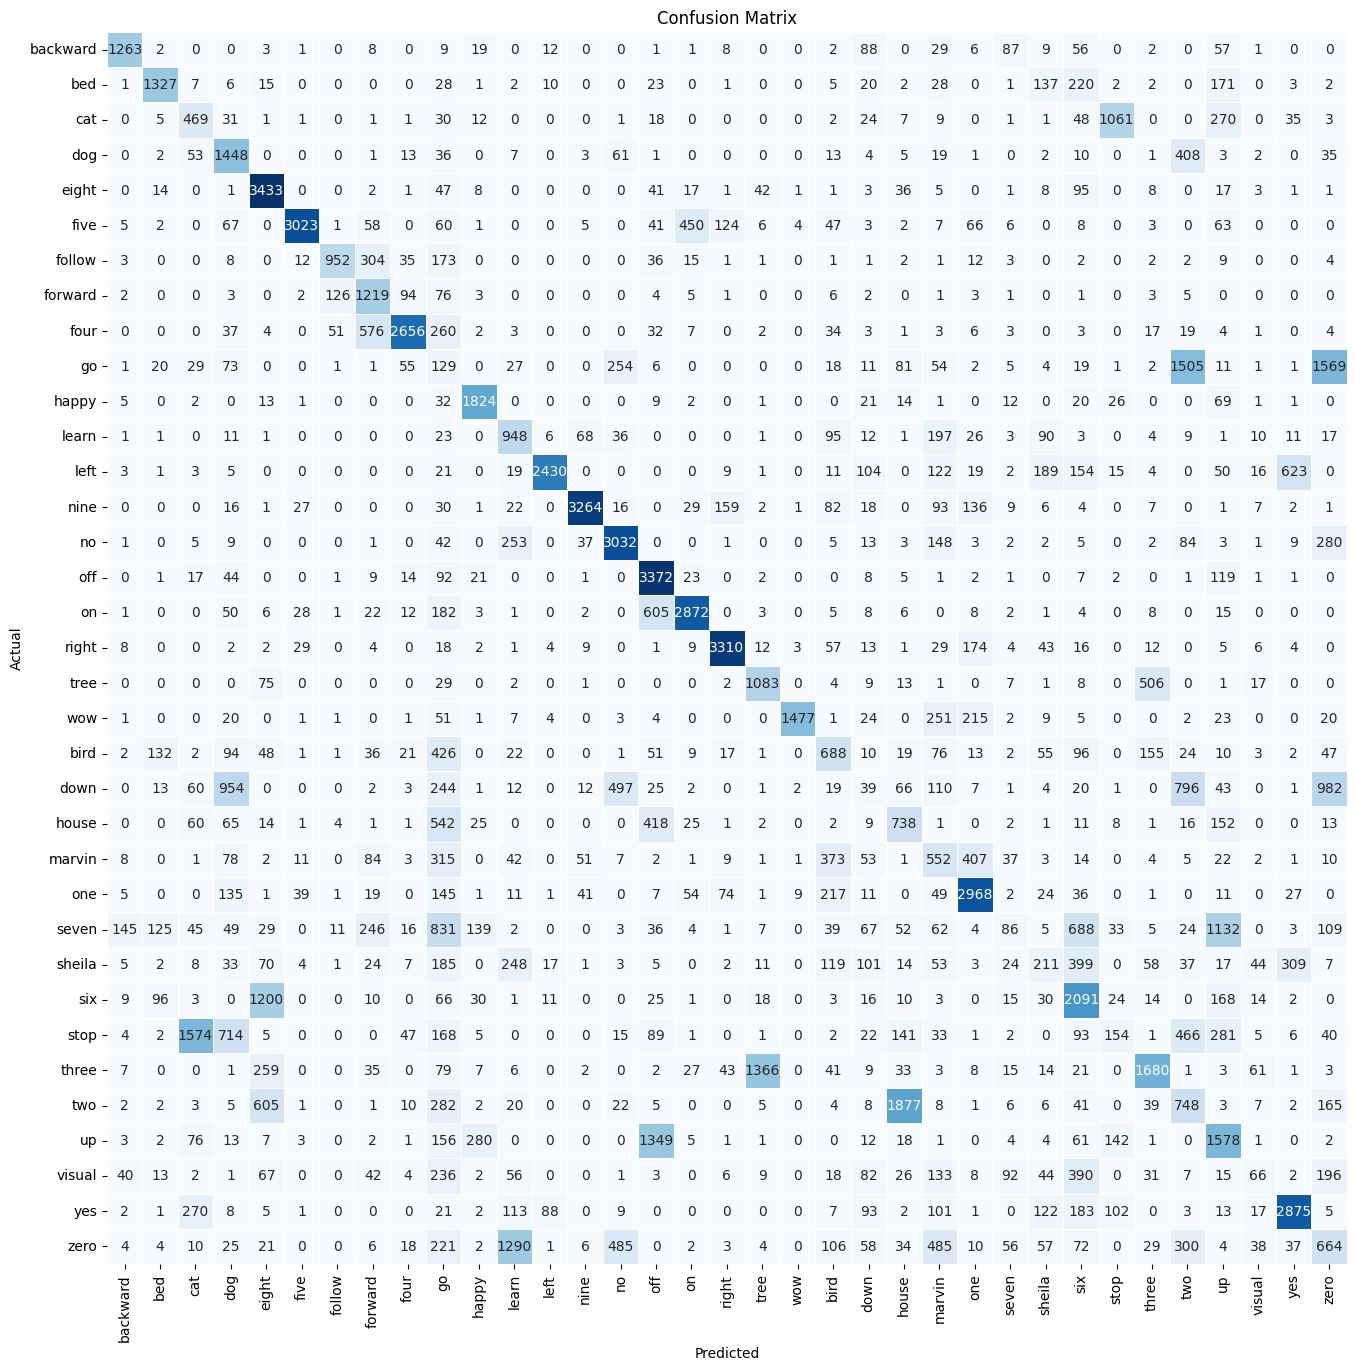

In [158]:
plt.figure(figsize=(16, 16))
sns.heatmap(confusion_mat_train, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False)

tick_marks = np.arange(len(all_class_names)) + 0.5
plt.xticks(tick_marks, all_class_names, rotation=90)
plt.yticks(tick_marks, all_class_names, rotation=0)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# SMTH

# SMTH

# SMTH